In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pickle
import random
from sklearn.model_selection import train_test_split, KFold

/Users/miaojiazheng/Downloads/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
pos = pd.read_csv("source_data/AMP0_data.csv")

In [3]:
# neg = []
# for dataset in ["train","test"]:
#     file = open("source_data/AMPlify_non_AMP/AMPlify_non_AMP_{}_balanced.fa".format(dataset),"r")
#     for line in file:
#         if line[0] != ">":
#             neg.append(line.split("\n")[0])
#     file.close()

In [4]:
# neglength = pd.Series(neg).apply(lambda x: len(x))
poslength = pos.drop_duplicates(["DBAASP ID"])["Sequence"].apply(lambda x: len(x))

<Axes: xlabel='Sequence', ylabel='Count'>

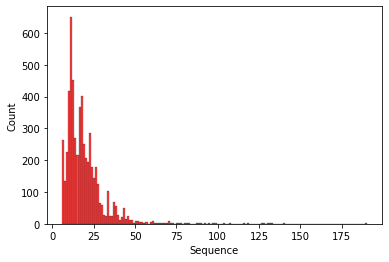

In [5]:
# sns.histplot(neglength, color="blue")
sns.histplot(poslength, color="red")

In [6]:
# transform = lambda x: 0.5+(0.5/(1+np.exp((x-105)/20)))
# mic = np.array([i for i in range(1000)])
# y = transform(mic)
# sns.lineplot(mic, y)

In [18]:
pos_seq = pos["Sequence"].values
pos_label = pos['MIC (?g/mL )'].apply(lambda x: np.log10(x+0.001)).values
pos_state = pos["Target species"].apply(lambda x: x.replace(" ", "_"))
# neg_seq = pd.Series(neg).sample(n=len(pos_seq), replace=True, random_state=8701).values
# neg_state = pos_state.sample(n=len(pos_seq), replace=True, random_state=8701).values
# neg_label = np.zeros(len(pos_seq))
# state = np.concatenate([pos_state.values, neg_state])
# label = np.concatenate([pos_label, neg_label])
# label = label.reshape(label.shape[0], 1)
# seq = np.concatenate([pos_seq, neg_seq])

In [19]:
pos_label

array([0.15162075, 2.45234585, 2.1927098 , ..., 1.86000957, 1.00004343,
       2.00000434])

<Axes: ylabel='Count'>

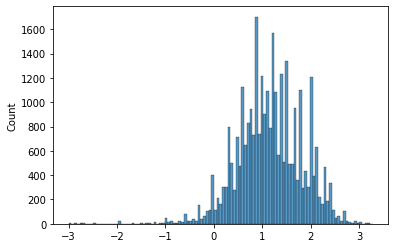

In [20]:
sns.histplot(pos_label)

In [21]:
species = pos_state.drop_duplicates().tolist()
SpeciesTV = tf.keras.layers.TextVectorization(standardize=None, split="whitespace", vocabulary=species,
                                          output_mode="multi_hot", name="SpeciesTextVectorizer")
SeqTV = tf.keras.layers.TextVectorization(max_tokens=200, standardize=None, split="character", pad_to_max_tokens=True,
                                          output_mode="int", name="SeqTextVectorizer")

In [22]:
enc_state = SpeciesTV(pos_state).numpy()
SeqTV.adapt(pos_seq)
enc_seq = SeqTV(pos_seq).numpy()

In [23]:
pickle.dump({'config': SpeciesTV.get_config(),
             'weights': SpeciesTV.get_weights()}
            , open("model_weights/SpeciesTextVectorizer.pkl", "wb"))

pickle.dump({'config': SeqTV.get_config(),
             'weights': SeqTV.get_weights()}
            , open("model_weights/SeqTextVectorizer.pkl", "wb"))

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=8701)

In [25]:
enc_seq = np.expand_dims(enc_seq, 2).astype("float32")
enc_state = np.expand_dims(enc_state, 2).astype("float32")
pos_label = np.expand_dims(pos_label, 1).astype("float32")

In [26]:
_, (cv_index, val_index) = list(enumerate(kf.split(pos_seq)))[0]
seq_cv = enc_seq[cv_index]
state_cv = enc_state[cv_index]
label_cv = pos_label[cv_index]
seq_val = enc_seq[val_index]
state_val = enc_state[val_index]
label_val = pos_label[val_index]

In [27]:
np.save("processed_data/val/seq_val", seq_val)
np.save("processed_data/val/state_val", state_val)
np.save("processed_data/val/label_val", label_val)

In [28]:
for i, (train_index, test_index) in enumerate(kf.split(seq_cv)):
    seq_train = seq_cv[train_index]
    state_train = state_cv[train_index]
    label_train = label_cv[train_index]
    seq_test = seq_cv[test_index]
    state_test = state_cv[test_index]
    label_test = label_cv[test_index]
    np.save("processed_data/cv/seq_train_{}".format(i), seq_train)
    np.save("processed_data/cv/state_train_{}".format(i), state_train)
    np.save("processed_data/cv/label_train_{}".format(i), label_train)
    np.save("processed_data/cv/seq_test_{}".format(i), seq_test)
    np.save("processed_data/cv/state_test_{}".format(i), state_test)
    np.save("processed_data/cv/label_test_{}".format(i), label_test)

In [37]:
x = np.arange(0.001, 100, 0.001)
y = np.log10(x) + x/10

/Users/miaojiazheng/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/miaojiazheng/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/miaojiazheng/Downloads/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

<Axes: >

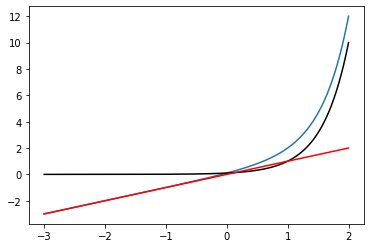

In [41]:
sns.lineplot(np.log10(x), y)
sns.lineplot(np.log10(x), x/10, color="black")
sns.lineplot(np.log10(x), np.log10(x), color="red")